In [1]:
#EP Phys 512
#Question 5

In [2]:
import numpy as np
import matplotlib.pyplot as mpl
from wmap_camb_example import get_spectrum
import corner

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

In [3]:
#providing chi2 for the data
def chi2(data, pars):
    ypred = get_spectrum(pars)
    ypred = ypred[2:1199+2] #chop down to correct size
    return np.sum( (data[:,1] - ypred)**2/data[:,2]**2 ) #wmap[:,1] =data , 2=std on data point

def acceptance_rate(chain):
    count = sum( (chain[1:, 0] - chain[0:-1, 0] ) != 0)
    acc_rate = count/chain.shape[0]
    print('total count is ', count)
    print('length of chain is ', chain.shape[0])
    print('acceptance rate is ', acc_rate)
    return acc_rate

#this prior method tries to scale the probability of acceptance to staying around tau's given mean and std
#it does this by incorporating the gaussian probability of tau in the acceptance criteria
def markov_cholesky_prior(pars, wmap, r, chi2fun, n):
    count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)
    
    #need information about prior on tau
    tau_mean = 0.0544
    tau_std = 0.0073
    tau_idx = 3 #third element in parameter array

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars + np.dot(r, np.random.randn(r.shape[0])) #add dist drawn from cholesky
        if pars_trial[tau_idx] > 0: #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            tau_gauss = np.exp(-0.5*( (pars_trial[tau_idx]-tau_mean)**2/tau_std**2)) #restricts step to desired tau
            accept_prob = tau_gauss*np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
        else: #tau was negative.
            count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
    print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau>0')
    return chain, chi2vec


#this markov chain tries to incorporate the prior on tau by restricting tau steps to within 1 sigma
def markov_cholesky_edge(pars, wmap, r, chi2fun, n):
    count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)
    
    #need information about prior on tau
    tau_mean = 0.0544
    tau_std = 0.0073
    tau_idx = 3 #third element in parameter array

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars + np.dot(r, np.random.randn(r.shape[0])) #add dist drawn from cholesky
        if (pars_trial[tau_idx] > (tau_mean - tau_std)) and (pars_trial[tau_idx] < (tau_mean + tau_std)): #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            accept_prob = np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
        else: #tau was negative.
            count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
    print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau within 1 sigma')
    return chain, chi2vec

def markov_stepsize_prior(pars, wmap, par_step, chi2fun, n):
#     count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)
    
    #need information about prior on tau
    tau_mean = 0.0544
    tau_std = 0.0073
    tau_idx = 3 #third element in parameter array

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars+np.random.randn(npar)*par_step #randomly add to each parameters
        if pars_trial[3] > 0: #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            tau_gauss = np.exp(-0.5*( (pars_trial[tau_idx]-tau_mean)**2/tau_std**2)) #restricts step to desired tau
            accept_prob = tau_gauss*np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
#         else: #tau was negative.
#             count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
#     print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau>0')
    return chain, chi2vec

(33068, 6)
(33068,)
mean would be  [7.04557043e+01 2.26871212e-02 1.11872307e-01 8.61259375e-02
 2.19340160e-09 9.77865014e-01]
errors would be  [2.70250010e+00 5.98881396e-04 5.59598042e-03 4.95085364e-02
 2.07539729e-10 1.71585411e-02]

 weighted mean is  [6.85407880e+01 2.21915872e-02 1.17112380e-01 5.28022730e-02
 2.08276906e-09 9.71689544e-01]
weighted errors are  [3.78893165e+00 9.17292416e-04 8.05371998e-03 4.72395116e-03
 4.60564007e-11 2.54723790e-02]


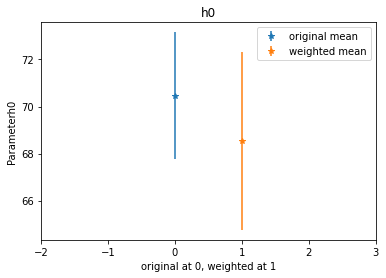

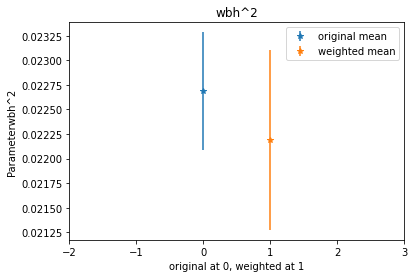

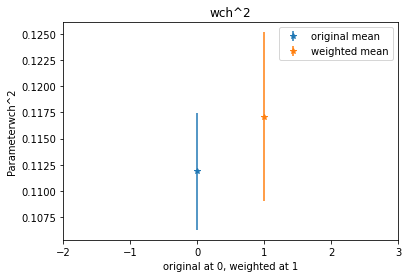

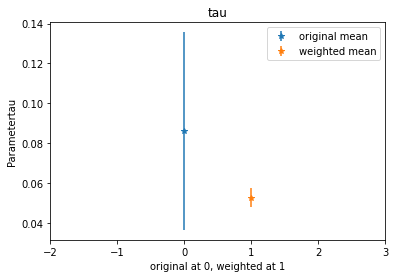

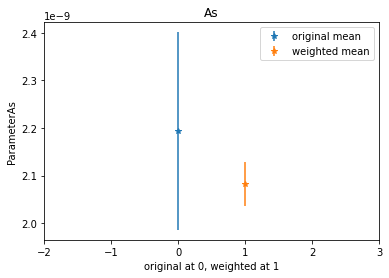

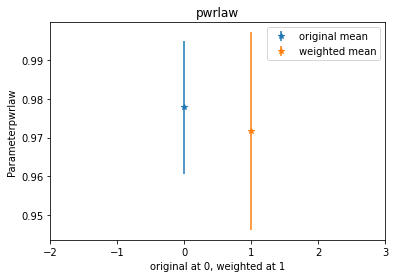

In [4]:
#IMPORTANCE SAMPLING
#given PRIOR on data samples, want to do importance weighting
#given information on tau. mean = 0.0544, std is 0.0073

chain = np.loadtxt("chain36k_nozeros.txt")
chi2vec = np.loadtxt("chi2vec36k_nozeros.txt")
print(chain.shape)
print(chi2vec.shape)

#obtain the mean and errors on the parameters without importance waiting
par_mean = np.mean(chain, axis=0)
par_errs = np.std(chain, axis=0)
print('mean would be ', par_mean)
print('errors would be ', par_errs)

#prior information on tau
tau_idx=3
tau_mean=0.0544
tau_std=0.0073

dchi2 = np.zeros(len(chi2vec))
dchi2 = chi2vec - np.median(chi2vec) #approximate delta chi squared

weights = np.exp(-0.5*( (chain[:,tau_idx]-tau_mean)**2/tau_std**2) + dchi2)

par_mean_weighted = np.zeros(chain.shape[1])
par_errs_weighted = np.zeros(chain.shape[1])
chain_scat = np.zeros(chain.shape)

#go through and get weighted mean for each parameter
for ii in range(chain.shape[1]):
    par_mean_weighted[ii] = np.sum(weights*chain[:, ii])/np.sum(weights)
    chain_scat[:, ii] = chain[:, ii] - par_mean_weighted[ii] #see how much chain moves around mean for each par
    par_errs_weighted[ii] = np.sqrt( np.sum( (chain_scat[:,ii]**2)*weights ) /np.sum(weights) ) #gives standard deviation
    
print('\n weighted mean is ', par_mean_weighted)
print('weighted errors are ', par_errs_weighted)

labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
for ii in range(chain.shape[1]):
    mpl.figure()
    mpl.title(labels[ii])
    mpl.errorbar(0, par_mean[ii], yerr=par_errs[ii], fmt='*')
    mpl.errorbar(1, par_mean_weighted[ii], yerr=par_errs_weighted[ii], fmt='*')
    mpl.xlabel('original at 0, weighted at 1')
    mpl.legend(['original mean', 'weighted mean'])
    mpl.ylabel('Parameter' + labels[ii])
    mpl.xlim([-2,3])
    mpl.show()

Performing the importance sampling using the information on tau greatly helps with the estimating the mean of tau, and greatly reduces the error on tau. However, the errors on most of the other parameters are increased slightly, but the tradeoff is actually having a reasonable tau, which is worth it.

In [5]:
# TIME TO RUN SOME MARKOV CHAINS
#set up some parameters

wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt') #this is the data

#use best fit parameters from previous section 3
pars = np.asarray([6.93351658e+01, 2.24911838e-02, 1.13886400e-01, 5.00000000e-02,
 2.04230773e-09, 9.69783026e-01])


#### MARKOV CHAIN FITTING STEPS

FIRST: compared two methods of sampling with the given information on tau.
changing the probability of acceptance by including the prior gaussian dist of tau into acceptance
making an edge where tau is not allowed to go out
sampled for 12000 points. 
used cholesky method.
not very converged at all, about 1% acceptance rate. as expected, the edge version had smaller errors on tau because it restricts it more, and slightly lower acceptance rate (0.12 rather than 0.14 for the other version).

SECOND: reran markov chain with the prior version with STEP SIZE rather than cholesky, step size and parameters drawn from new errors.



In [6]:
#SAMPLING WITH A PRIOR
#before we've already seen sampling with an edge saying that tau>0
#here we want to restrict tau from leaving the vicinity of the mean 0.0544 with std 0.0073

if False: #if we want to fit using the cholesky matrix from part 3
    
    #generate cholesky matrix
    mat = np.loadtxt('newton_lhs.txt')
    r = np.linalg.cholesky(np.linalg.inv(mat)) #create cholesky matrix for generating pars

    n=12000
    #using the prior this way will drop acceptance, we'll see by how much, less steps accepted
    chain_prior, chi2vec_prior = markov_cholesky_prior(pars, wmap, r, chi2, n)
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain_prior))
    
#     np.savetxt('chainprior.txt', chain_prior)
#     np.savetxt('chi2vecprior.txt', chi2vec_prior)
    
    #copy matrices. paranoid of accidental erasures even after they're written to txt
    chain = chain_prior.copy()
    chi2vec = chi2vec_prior.copy()

In [7]:
#SAMPLING WITH A STRICTER EDGE
#before we've already seen sampling with an edge saying that tau>0
#here we want to restrict tau from leaving the vicinity of the mean 0.0544 with std 0.0073

if False: #if we want to fit using the cholesky matrix from part 3
    
    #generate cholesky matrix
    mat = np.loadtxt('newton_lhs.txt')
    r = np.linalg.cholesky(np.linalg.inv(mat)) #create cholesky matrix for generating pars

    n=12000
    #using the prior this way will drop acceptance, we'll see by how much, less steps accepted
    chain_edge, chi2vec_edge = markov_cholesky_edge(pars, wmap, r, chi2, n)
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain_edge))
    
#     np.savetxt('chainedge.txt', chain_edge)
#     np.savetxt('chi2vecedge.txt', chi2vec_edge)
    
    #copy matrices. paranoid of accidental erasures even after they're written to txt
    chain = chain_edge.copy()
    chi2vec = chi2vec_edge.copy()

In [8]:
#SAMPLING WITH PRIORS AND NEW STEP SIZES AND PARAMETERS

if False:
    chain_prev = np.loadtxt('chainprior12k.txt')
    pars = np.mean(chain_prev, axis=0)
    par_step = np.std(chain_prev, axis=0)

    print('parameters and step size going in are \n', pars, ' \n', par_step)

    n = 10000
    
    chain_prior_step, chi2vec_prior_step = markov_stepsize_prior(pars, wmap, par_step, chi2, n)
    
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain_prior_step))

    np.savetxt('chainpriorstep.txt', chain_prior_step)
    np.savetxt('chi2vecpriorstep.txt', chi2vec_prior_step)
    
    #copy matrices. paranoid of accidental erasures even after they're written to txt
    chain = chain_prior_step.copy()
    chi2vec = chi2vec_prior_step.copy()
    

parameters and step size going in are 
 [6.94441481e+01 2.24548405e-02 1.13681562e-01 5.36210209e-02
 2.05603039e-09 9.70169532e-01]  
 [2.01295807e+00 4.27450789e-04 4.41514850e-03 8.18286104e-03
 4.62069645e-11 1.15367064e-02]
our current chi2 value is  1227.9841969662436
total count is  142
length of chain is  10000
acceptance rate is  0.0142
finished cholesky chain with acceptance rate  0.0142


In [9]:
#load data rather than regenerate

# chain = np.loadtxt('chainprior.txt')
# chi2vec = np.loadtxt('chi2vecprior.txt')

# chain = np.loadtxt('chainedge.txt')
# chi2vec = np.loadtxt('chi2vecedge.txt')

chain sigmas are  [1.99251156e+00 4.19259536e-04 5.35972715e-03 5.93444556e-03
 5.80992251e-11 1.07180221e-02]
chain means are  [7.02944929e+01 2.25536054e-02 1.11838320e-01 5.47305688e-02
 2.04820714e-09 9.73491436e-01]
total count is  142
length of chain is  10000
acceptance rate is  0.0142
the acceptance rate of the chain is  0.0142


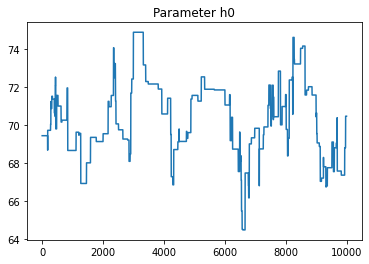

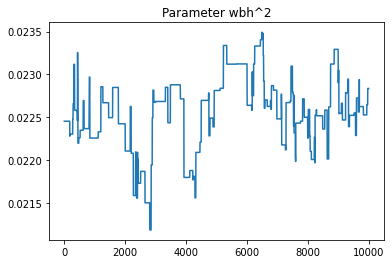

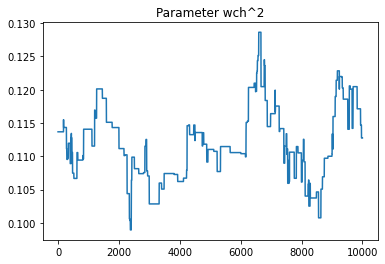

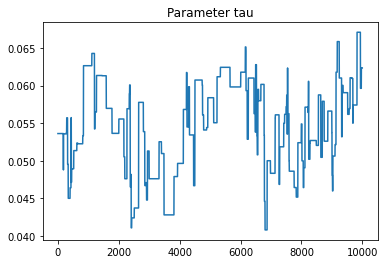

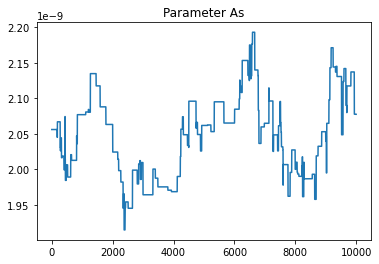

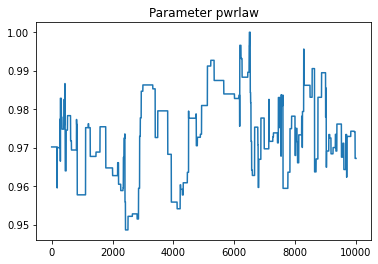

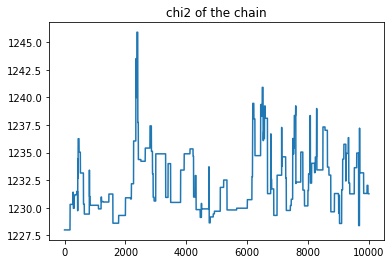

In [10]:
print('chain sigmas are ', np.std(chain, axis=0))
print('chain means are ', np.mean(chain, axis=0))
print('the acceptance rate of the chain is ', acceptance_rate(chain))

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
for ii in range(len(pars)):
    mpl.figure()
    mpl.plot(chain[:, ii])
    mpl.title('Parameter ' + par_lab[ii])
    mpl.show()
    
mpl.figure()
mpl.plot(chi2vec)
mpl.title('chi2 of the chain')
mpl.show()

corner plot of chain 


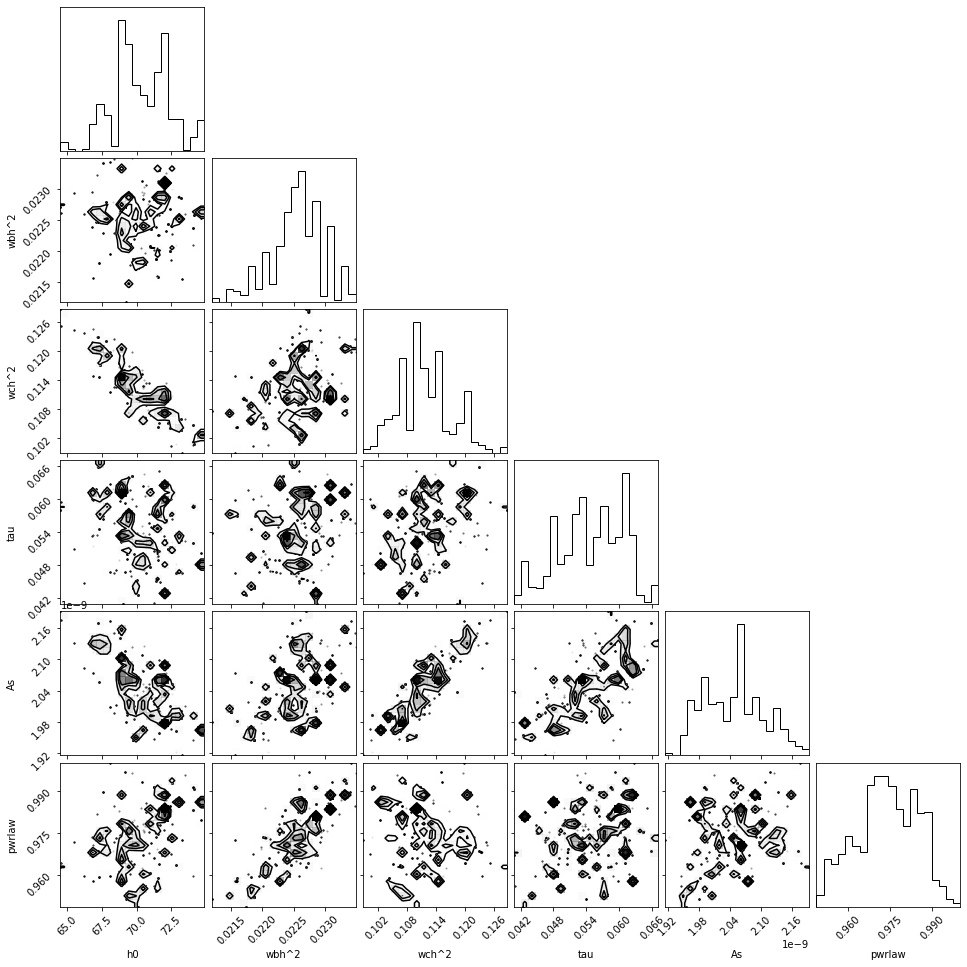

In [11]:
print('corner plot of chain ')
figure = corner.corner(chain, labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw'])